In [32]:
# Notebook re-used from: https://github.com/taochenshh/Expectation-Maximization-Gaussian-Mixtures/blob/master/EM-for-gmm.ipynb
  
import numpy as np
import matplotlib.pyplot as plt 
import copy
from scipy.stats import multivariate_normal

%matplotlib inline

In [33]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

In [34]:
# Model parameters
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

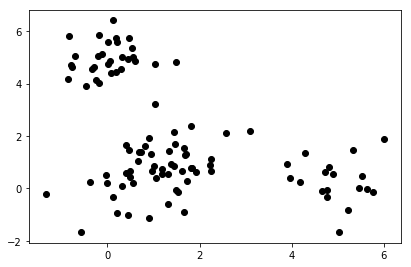

In [35]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [36]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

In [37]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for i in range(maxiter):
        if i % 5 == 0:
            print("Iteration %s" % i)
        
        # E-step: compute responsibilities
        # Update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j.
        # Hint: To compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf.
        for j in range(num_data):
            for k in range(num_clusters):
                resp[j, k] =  weights[k] * multivariate_normal.pdf(data[j], mean=means[k], cov=covariances[k])
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        resp = resp / row_sums # normalize over all possible cluster assignments

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. In the lectures this is called N^{soft}
        counts = np.sum(resp, axis=0)
        
        for k in range(num_clusters):
            
            # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
            weights[k] = counts[k]
            
            # Update means for cluster k using the M-step update rule for the mean variables.
            # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
            
            weighted_sum = 0
            for j in range(num_data):
                weighted_sum += data[j] * resp[j,k]
            means[k] = weighted_sum / weights[k]
            
            # Update covariances for cluster k using the M-step update rule for covariance variables.
            # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
            weighted_sum = np.zeros((num_dim, num_dim))
            for j in range(num_data):
                #(Hint: Use np.outer on the data[j] and this cluster's mean)
                weighted_sum += np.outer(data[j] - means[k],data[j] - means[k]) * resp[j,k]

            covariances[k] = weighted_sum / weights[k]

        
        
        # Compute the loglikelihood at this iteration
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if i % 5 != 0:
        print("Iteration %s" % i)
    weights = weights / sum(weights)
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

In [38]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3
# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


In [39]:
import matplotlib.mlab as mlab
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

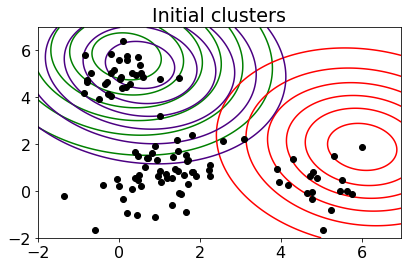

In [40]:
# Parameters after initialization
plot_contours(data, initial_means, initial_covs, 'Initial clusters')

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


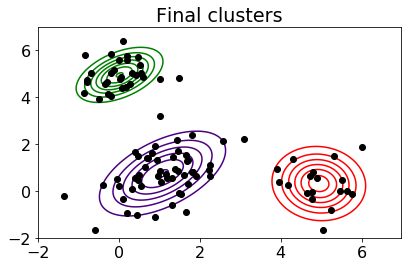

In [41]:
# Parameters after running EM to convergence
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Final clusters')